# Lab 6: Convolutional Neural Network

### *Harrison Noble & Henry Lambson*

***

__Dataset Selection__

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import zipfile
import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from sklearn.utils import shuffle

print(keras.__version__)
print(tf.__version__)

2.3.0-tf
2.1.3


In [2]:
#This preprocessing code is modified from our Lab 2 report
#unzip data (only do once, uncomment to unzip data)
# with zipfile.ZipFile('dataset.zip', 'r') as zipf:
#     zipf.extractall('./data')

fake_face_path = 'data/real_and_fake_face/training_fake/*'
real_face_path = 'data/real_and_fake_face/training_real/*'

#desired height and width of images
h = 75
w = 75

np.random.seed(0)

def load_data(path):
    files = glob.glob(path)
    img_list = []
    classes = []
    for file in files:
        #create image, convert to grayscale, resize
        img = np.asarray(Image.open(file).convert('L').resize((h, w)))
        img_list.append(img)
        _, fname = os.path.split(file)
        classes.append(1 if 'real' in fname else 0)
    
    return np.asarray(img_list), np.asarray(classes)

fake_list, fake_classes = load_data(fake_face_path)
real_list, real_classes = load_data(real_face_path)
print('Fake images dataset shape:', fake_list.shape)
print('Real images dataset shape:', real_list.shape)

#combine data, normalize pixel data, shuffle
data = np.concatenate((fake_list, real_list), axis=0)
data = data/255.0-0.5
data = np.expand_dims(data, axis=-1)
classes = np.concatenate((fake_classes, real_classes), axis=0)
data, classes = shuffle(data, classes, random_state=0)

print('Total dataset shape:', data.shape)
print('Total number of classification targets:', classes.shape)

Fake images dataset shape: (960, 75, 75)
Real images dataset shape: (1081, 75, 75)
Total dataset shape: (2041, 75, 75, 1)
Total number of classification targets: (2041,)


The above code is a modified version of our loading and pre-processing from Lab 2. This code loads all the images, converts to grayscale, uniformally resizes them to 75x75 pixels, and normalizes the pixel values. Our preprocessed image dataset is stored as the ```data``` numpy array. Additionally, the class labels for each image are stored in the ```classes``` list. 

Our dataset contains 960 edited/fake images (47%) and 1081 real images of people (53%), which is balanced fairly well. The main classification task of our dataset is to determine whether a given image is fake or real. We think this can be incorporated into a social media site that runs a preliminary screening over a photo before it is posted to flag all edited photos for review.

The shape of our combined fake and real image dataset is 2041x75x75x1, meaning there are 2041 images, each of size 75x75 pixels with 1 color channel (grayscale).

0 = Fake Image, 1 = Real Image


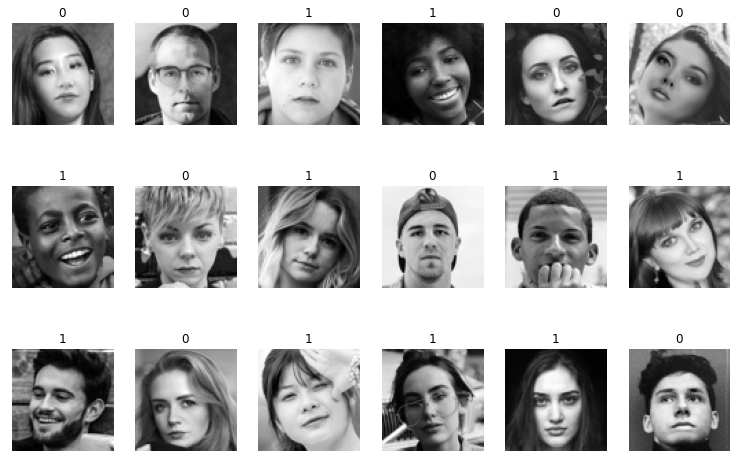

In [3]:
#taken from your 11. Convolutional Neural Networks notebook
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    print('0 = Fake Image, 1 = Real Image')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(data, classes, 75, 75)

The above images show a small subset of our data. The images with a label of 1 are real photos and images with a label of 0 are fake, edited photos. Some fake images are much harder to distinguish from real ones, while some are very easy to distinguish. 

***

## 1 Preparation

### 1.1 Evaluation Metric Selection

Although our dataset is fairly balanced and we care about both classes equally, we decided to go with the F1-Score for our evaluation metric. F1-Score is the middle ground between precision and recall. Precision measures the true positives over all predicted positives (false positives) and recall measures the predicted positives instance to the total number of positive instances (false negatives). In our case, we want to minimize both false positives and false negatives, which is why we think F1-Score is a good evaluation metric. If our model were to be used as a preliminary screening method for a social media site, we would not want to flag legitimate photos as edited (false positive), nor would we want to let an edited picture get through our algorithm (false negative). A high false positive rate would lead to an unnecessary amount of flagging, whereas a high false negative rate would render our "edited photo detection" algorithm fairly useless.

Below is the code used to calculate the F1-Score evaluation metric which will be passed into our models later.

In [4]:
from tensorflow.keras import backend as K

#code used from [2]
def f1(y_true, y_pred):
    #calc recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    #calc precision
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    #calc f1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 1.2 Method to Divide Data into Training & Testing

We decided to use an 80/20 stratified shuffle split to divide our data into training and testing sets. We believe stratified shuffle split works with our dataset as it is fairly balanced already, and this method of splitting the data would further preserve this balance. Due to hardware/time constrains (CNN training time and plenty of other projects due), we decided not to use stratified K-fold cross validation as this significantly increases the time to train the models. Additionally, by using data expansion we can increase the number of images our model trains on. Therefore we believe an 80/20 stratified shuffle split is sufficient for our modeling needs.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data
y = np.asarray(classes)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)

X_train shape: (1632, 75, 75, 1) , y_train shape: (1632, 2)
X_test shape: (409, 75, 75, 1) , y_test shape: (409, 2)


From those numbers, we can see that the data has been split into 80% training and 20% testing, lets make sure the class balance stayed around 47% for the fake images and 53% for the real images.

In [6]:

print("y_train class balance:", np.sum(y_train[:,0] == 1), np.sum(y_train[:,1] == 1))
print("y_test class balance:", np.sum(y_test[:,0] == 1), np.sum(y_test[:,1] == 1))

y_train class balance: 768 864
y_test class balance: 192 217


Looks good, the class with the smaller number of instances makes up about 47% of both training and testing data.

***

## 2 Modeling

### 2.1 Data Expansion

For data expansion, we decided to use the Keras ```ImageDataGenerator``` to modify/expand our data. We settled on using augmentation like image rotation, shifting the height and width, messing with zooming in, and flipping the image horizontally. We thought these were good apsects to change as our data is comprised of photos of people and people can do a variety of different poses in their pictures. Not every picture we send through our algorithm is going to be a straight on headshot so we are accounting for that during data augmentation/expansion.

0 = Fake Image, 1 = Real Image


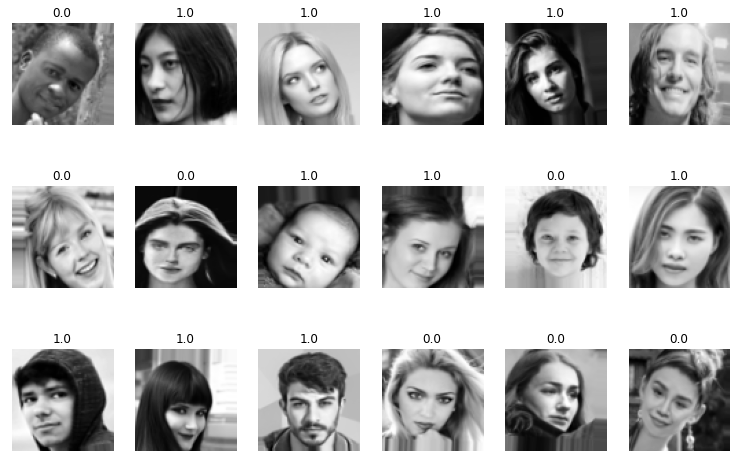

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    data_format="channels_last")

datagen.fit(X_train)
tmps = datagen.flow(X_train, y_train, batch_size=18)

plot_gallery(tmps[0][0], tmps[0][1][:,1], 75, 75)

From the above image outputs we can see how the images look slightly altered from a normal image. Visibly, we can see that some of the faces have been shifted towards the edges of the frame while some are rotated slightly.

### 2.2 Convolutional Neural Networks

#### 2.2.1 Model 1

For our first model we decided to make a network with 4 convolutional layers, each with 32 filters, a 3x3 kernel, max pooling, L2 regularization, and He uniform initialization. We also decided to add some batch normalization after each convolutional layer (before the pooling) so that we can cut down the number of epochs needed to train the data. Without the batch normalization, our models would take significantly more epochs to train (about 200 compared to the 55 we use below). After the convolutional layers, we added some dropout, a dense layer with 128 neurons, some more dropout, and finally our output layer. We settled on Adam for our optimizer because we found this to work best. 

In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Input, Add, average, concatenate
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import average
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

In [14]:
#helper function to print plots of evaluation metric and loss function over # of epochs
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('Evaluation Metric')
    plt.plot(hist.history['f1'], label='Training F1')
    plt.plot(hist.history['val_f1'], label='Validation F1')
    plt.ylabel('F1-Score')
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(False)
    
    plt.subplot(1,2,2)
    plt.title('Loss Function')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(False)
    plt.show()

In [15]:
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

l2_lambda = 0.000001
HEIGHT = 75
WIDTH = 75

cnn1 = Sequential()
cnn1.add(Conv2D(filters=32,
                input_shape=(HEIGHT,WIDTH,1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Flatten())
cnn1.add(Dropout(0.3))
cnn1.add(Dense(units=128,
               activation='relu',
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
cnn1.add(Dropout(0.3))
cnn1.add(Dense(units=2,
               activation='softmax',
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

cnn1.compile(optimizer=Adam(),
             loss='categorical_crossentropy',
             metrics=[f1])
cnn1.summary()
hist1 = cnn1.fit(datagen.flow(X_train, y_train, batch_size=64), 
                 steps_per_epoch=int(len(X_train)/64),
                 epochs=55,
                 verbose=1,
                 validation_data=(X_test,y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9

Epoch 43/55
25/25 [==============================] - 5s 205ms/step - loss: 0.6444 - f1: 0.6244 - val_loss: 0.6484 - val_f1: 0.6497
Epoch 44/55
25/25 [==============================] - 5s 208ms/step - loss: 0.6402 - f1: 0.6231 - val_loss: 0.6482 - val_f1: 0.6612
Epoch 45/55
25/25 [==============================] - 5s 207ms/step - loss: 0.6285 - f1: 0.6425 - val_loss: 0.6430 - val_f1: 0.6507
Epoch 46/55
25/25 [==============================] - 5s 205ms/step - loss: 0.6344 - f1: 0.6369 - val_loss: 0.6451 - val_f1: 0.6408
Epoch 47/55
25/25 [==============================] - 5s 204ms/step - loss: 0.6335 - f1: 0.6475 - val_loss: 0.6527 - val_f1: 0.6264
Epoch 48/55
25/25 [==============================] - 5s 203ms/step - loss: 0.6272 - f1: 0.6475 - val_loss: 0.6432 - val_f1: 0.6743
Epoch 49/55
25/25 [==============================] - 5s 204ms/step - loss: 0.6157 - f1: 0.6481 - val_loss: 0.6302 - val_f1: 0.6629
Epoch 50/55
25/25 [==============================] - 5s 206ms/step - loss: 0.6130 -

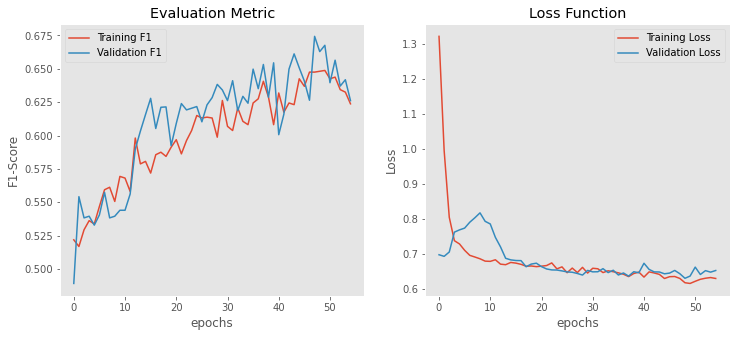

Loss: 0.6524676234623039 F1-Score: 0.6220192


In [16]:
plot_history(hist1)
loss, f1_score = cnn1.evaluate(X_test, y_test, verbose=0)
print('Loss:', loss, 'F1-Score:', f1_score)

From the above graphs, we can see that our first convolutional model has a peak validation F1-Score of about 0.675 at epoch 48 and starts to decrease after that. The validation loss starts by increasing during the first 10 epochs but then corrects itself and starts decreasing to about 0.65 at the end of training. This model does not seem to overfit as the training F1-Score is pretty much always lower or equal to the validation F1-Score. This model performs around 10% better than just always picking the dominant classification (about 53% of the data is real photos). The evaluation function after training finishes puts our F1-Score at 0.62 and our loss at 0.65.

Looking at the evaluation metric graph, the F1-Score seems to bounce around without increasing smoothly. After testing with different optimizers and optimizer parameters, this was the best looking network we were able to create so far. We think this "bouncing around" behavior could be due to the way our optimizer moves about the gradient for our dataset.

#### 2.2.2 Model 1 Variation

For our first model variation we decided to increase the number of filters for each convolutional layer to 64 and increase the kernel size to 5x5. All other parameters are the same as the previous model. 

In [17]:
l2_lambda = 0.000001

cnn2 = Sequential()
cnn2.add(Conv2D(filters=64,
                input_shape=(HEIGHT,WIDTH,1),
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn2.add(Conv2D(filters=64,
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn2.add(Conv2D(filters=64,
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn2.add(Conv2D(filters=64,
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format='channels_last'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn2.add(Flatten())
cnn2.add(Dropout(0.3))
cnn2.add(Dense(units=128,
               activation='relu',
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
cnn2.add(Dropout(0.3))
cnn2.add(Dense(units=2,
               activation='softmax',
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

cnn2.compile(optimizer=Adam(),
             loss='categorical_crossentropy',
             metrics=[f1])
cnn2.summary()
hist2 = cnn2.fit(datagen.flow(X_train, y_train, batch_size=64), 
                 steps_per_epoch=int(len(X_train)/64),
                 epochs=55,
                 verbose=1,
                 validation_data=(X_test,y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 75, 75, 64)        1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 64)       

25/25 [==============================] - 21s 831ms/step - loss: 0.6181 - f1: 0.6562 - val_loss: 0.6460 - val_f1: 0.6112
Epoch 43/55
25/25 [==============================] - 21s 842ms/step - loss: 0.6124 - f1: 0.6644 - val_loss: 0.6722 - val_f1: 0.6195
Epoch 44/55
25/25 [==============================] - 21s 851ms/step - loss: 0.6067 - f1: 0.6525 - val_loss: 0.6552 - val_f1: 0.6157
Epoch 45/55
25/25 [==============================] - 21s 838ms/step - loss: 0.6056 - f1: 0.6750 - val_loss: 0.6665 - val_f1: 0.6145
Epoch 46/55
25/25 [==============================] - 23s 914ms/step - loss: 0.5888 - f1: 0.6800 - val_loss: 0.6789 - val_f1: 0.5795
Epoch 47/55
25/25 [==============================] - 21s 834ms/step - loss: 0.5846 - f1: 0.6794 - val_loss: 0.6797 - val_f1: 0.6021
Epoch 48/55
25/25 [==============================] - 21s 840ms/step - loss: 0.5813 - f1: 0.6825 - val_loss: 0.6605 - val_f1: 0.6301
Epoch 49/55
25/25 [==============================] - 21s 835ms/step - loss: 0.5922 - f1:

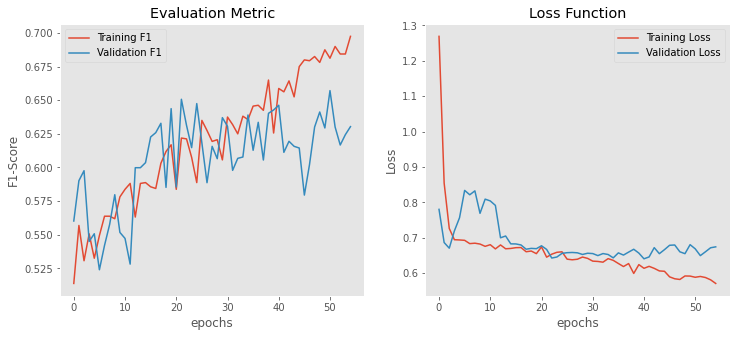

Loss: 0.6744637807015976 F1-Score: 0.6326923


In [18]:
plot_history(hist2)
loss, f1_score = cnn2.evaluate(X_test, y_test, verbose=0)
print('Loss:', loss, 'F1-Score:', f1_score)

From the above graphs, we can see that our first model variant seemed to struggle with overfitting towards the end of training. Around epoch 40 the training F1-Score steadily increases while our validation F1-Score stays about the same. Additionally, the validation loss starts to rise again around epoch 40 while the training loss continues to fall. We see the same issue with the validation F1-Score bouncing around as we did with our first model, however, this model seems to bounce around more. The loss graph also follows a similar trend, rising at the beginning then going back down, but this time it starts to rise again towards the end due to the overfitting. 

The evaluation function for this model outputs a loss of 0.67 and a F1-Score of 0.63. We find this F1-Score a bit weird as it is 0.01 higher than our previous model, yet looking at the graph it seems like this model is significantly worse. We will need to do some statistical tests later on in Section 2.3 to determine what is happening.

We think the overfitting is due to the increased number of filters and kernel size. The increased filters/kernel could be memorizing the images instead of learning general trends among the fake and real images. To fix this we might want to add more dropout or normalization in the network. 

#### 2.2.3 Model 2

For our second model we decided to use the Xception architecture as seen in your "12. More Advanced CNN Techniques" notebook. One thing we did change about this architecture is that we added batch normalization after each convolutional/separable convolutional layer. Similar to the last model, we use 32 filters, a 3x3 kernel, He uniform kernel initialization, and L2 regularization. After the convolutional layers, we add some dropout, a dense layer with 128 neurons, more dropout, and our output layer. 

In [19]:
l2_lambda = 0.000001

input_holder = Input(shape=(HEIGHT, WIDTH, 1))
x = Conv2D(filters=32,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = BatchNormalization()(x)
x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, 
               data_format="channels_last")(x_split)
x = BatchNormalization()(x)
x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, 
               data_format="channels_last")(x_split)
x = BatchNormalization()(x)
x_split = Add()([x, x_split])
x = Activation("relu")(x_split)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)
xception.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=[f1])
xception.summary()
hist3 = xception.fit(datagen.flow(X_train, y_train, batch_size=64), 
                     steps_per_epoch=int(len(X_train)/64),
                     epochs=55,
                     verbose=1,
                     validation_data=(X_test,y_test))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 75, 75, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 75, 75, 32)   128         conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 37, 37, 32)   0           batch_normalization_8[0][0]      
______________________________________________________________________________________________

25/25 [==============================] - 6s 238ms/step - loss: 0.6755 - f1: 0.5519 - val_loss: 0.6747 - val_f1: 0.6061
Epoch 28/55
25/25 [==============================] - 7s 275ms/step - loss: 0.6748 - f1: 0.5544 - val_loss: 0.6689 - val_f1: 0.5959
Epoch 29/55
25/25 [==============================] - 5s 215ms/step - loss: 0.6730 - f1: 0.5500 - val_loss: 0.6671 - val_f1: 0.6029
Epoch 30/55
25/25 [==============================] - 5s 214ms/step - loss: 0.6751 - f1: 0.5756 - val_loss: 0.6699 - val_f1: 0.5939
Epoch 31/55
25/25 [==============================] - 5s 214ms/step - loss: 0.6817 - f1: 0.5425 - val_loss: 0.6778 - val_f1: 0.5691
Epoch 32/55
25/25 [==============================] - 5s 216ms/step - loss: 0.6774 - f1: 0.5469 - val_loss: 0.6741 - val_f1: 0.6029
Epoch 33/55
25/25 [==============================] - 5s 215ms/step - loss: 0.6779 - f1: 0.5569 - val_loss: 0.6735 - val_f1: 0.5971
Epoch 34/55
25/25 [==============================] - 5s 215ms/step - loss: 0.6749 - f1: 0.5669 

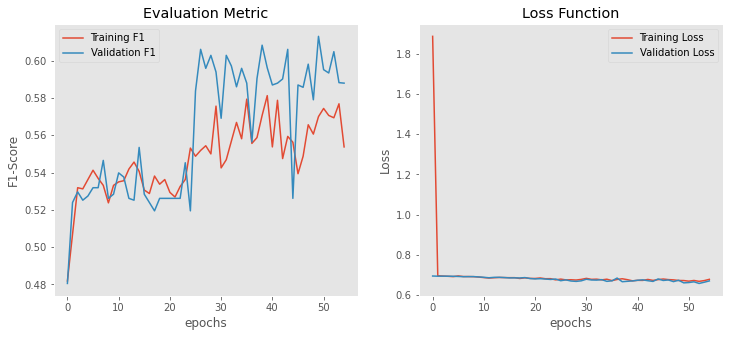

Loss: 0.6694615984604236 F1-Score: 0.5870192


In [21]:
plot_history(hist3)
loss, f1_score = xception.evaluate(X_test, y_test, verbose=0)
print('Loss:', loss, 'F1-Score:', f1_score)

So far, this model seems to have the worst performance out of all models. The validation F1-Score peaks at around 0.61 at epoch 50 but jumps around quite a lot in the later epochs. The validation loss does not look good at all. The loss has a very slight decline but not the logarithmic type curve we expect to see. The final evaluation function puts our loss at 0.67 and our F1-Score at 0.58, only about 5% better than a model that only selects the dominant class. We think that there are significant issues with this model and we are hoping that changing some parameters will alleviate some of these issues. Additionally, there doesn't seem to be an issue with overfitting as the validation F1-Score is generally greater than the training F1-Score.

#### 2.2.4 Model 2 Variation

For our model 2 variation we decided to increase the number of filters to 64 and increase the kernel size to 5x5 (just like the model 1 variation). All other aspects of the convolutional network are the same. 

In [22]:
l2_lambda = 0.000001

input_holder = Input(shape=(HEIGHT, WIDTH, 1))
x = Conv2D(filters=64,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = BatchNormalization()(x)
x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=64,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1,
               data_format="channels_last")(x_split)
x = BatchNormalization()(x)
x_split = Add()([x, x_split])

x = SeparableConv2D(filters=64,
               input_shape = (HEIGHT, WIDTH, 1),
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1,
               data_format="channels_last")(x_split)
x = BatchNormalization()(x)
x_split = Add()([x, x_split])
x = Activation("relu")(x_split)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2,activation="softmax")(x)

xception2 = Model(inputs=input_holder,outputs=x)
xception2.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[f1])
xception2.summary()
hist4 = xception2.fit(datagen.flow(X_train, y_train, batch_size=64), 
                      steps_per_epoch=int(len(X_train)/64),
                      epochs=55,
                      verbose=1,
                      validation_data=(X_test,y_test))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 75, 75, 64)   1664        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 75, 75, 64)   256         conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 37, 37, 64)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

Epoch 27/55
25/25 [==============================] - 21s 854ms/step - loss: 0.6854 - f1: 0.5556 - val_loss: 0.6730 - val_f1: 0.5686
Epoch 28/55
25/25 [==============================] - 21s 855ms/step - loss: 0.6782 - f1: 0.5700 - val_loss: 0.6724 - val_f1: 0.6068
Epoch 29/55
25/25 [==============================] - 21s 853ms/step - loss: 0.6776 - f1: 0.5694 - val_loss: 0.6691 - val_f1: 0.6125
Epoch 30/55
25/25 [==============================] - 22s 864ms/step - loss: 0.6766 - f1: 0.5750 - val_loss: 0.6789 - val_f1: 0.5854
Epoch 31/55
25/25 [==============================] - 24s 946ms/step - loss: 0.6787 - f1: 0.5781 - val_loss: 0.6737 - val_f1: 0.5976
Epoch 32/55
25/25 [==============================] - 22s 874ms/step - loss: 0.6747 - f1: 0.5850 - val_loss: 0.6669 - val_f1: 0.6304
Epoch 33/55
25/25 [==============================] - 22s 865ms/step - loss: 0.6771 - f1: 0.5769 - val_loss: 0.6695 - val_f1: 0.6122
Epoch 34/55
25/25 [==============================] - 21s 856ms/step - loss: 

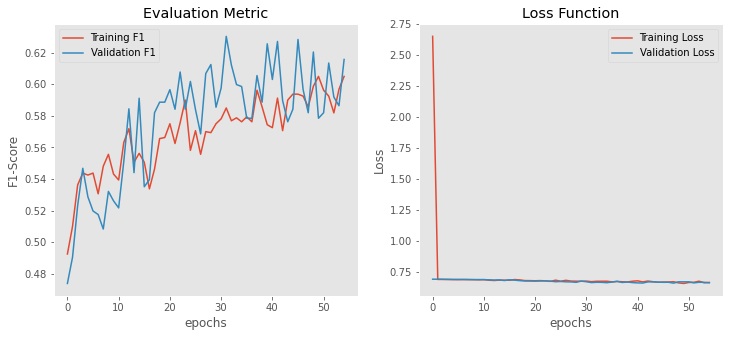

Loss: 0.6657419550098242 F1-Score: 0.61999995


In [23]:
plot_history(hist4)
loss, f1_score = xception2.evaluate(X_test, y_test, verbose=0)
print('Loss:', loss, 'F1-Score:', f1_score)

This model seems to have slightly better performance compared to the original model 2. Our validation loss still looks terrible but our final F1-Score is 0.62, 0.04 greater than the previous model, and our final loss is 0.66, 0.01 less than the previous model. This model performs more similarly to the first model and first model variation. Similarly to the previous model, overfitting does not seem to be an issue here either.

Let's now get into some further analysis on each of our models.

### 2.3 Analyzing & Visualizing CNN Results

From the graphs shown in the above section, we can see that our models do not perform great... By only looking at the graphs, our best performing model seems to be either model 1 or the model 1 variation with a F1-Score of 0.62 and 0.63 respectively and loss of 0.65 and 0.67 respectively. Through looking at other convolutional neural network examples on this dataset [3], our best model performance is on par with the convolutional models created by other people (excluding the models using pre-trained networks on top of theirs). The non-pre-trained models seemed to get an accuracy score of around 60-65% (accuracy is comparable to our F1-Score since dataset is fairly balanced), while the models using pre-trained networks achieved around a 90% accuracy. 

It appears that this classification task is much more difficult for a convolutional network than we originally thought and a much more powerful network is required to achieve a high evaluation score. Let's now go into some statistical tests to see if any models are statistically better than the others. Because we already visualized the loss and performance over the number of epochs in the previous section, this section will mainly focus on the analysis of each convolutional neural network. 

In [32]:
yhat1 = np.round(cnn1.predict(X_test))
yhat2 = np.round(cnn2.predict(X_test))
yhat3 = np.round(xception.predict(X_test))
yhat4 = np.round(xception2.predict(X_test))

err1 = 1 - f1(yhat1, y_test)
err2 = 1 - f1(yhat2, y_test)
err3 = 1 - f1(yhat3, y_test)
err4 = 1 - f1(yhat4, y_test)

print('Error rate of model 1:', err1.numpy())
print('Error rate of model 1 variant:', err2.numpy())
print('Error rate of model 2:', err3.numpy())
print('Error rate of model 2 variant:', err4.numpy())

d = np.abs(err1 - err2)
var = (err2 * (1-err2)/X_test.size) + (err1 * (1-err1)/X_test.size)
print('\nConfidence interval of model 1 and model 1 variant:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err1 - err3)
var = (err3 * (1-err3)/X_test.size) + (err1 * (1-err1)/X_test.size)
print('Confidence interval of model 1 and model 2:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err1 - err4)
var = (err4 * (1-err4)/X_test.size) + (err1 * (1-err1)/X_test.size)
print('Confidence interval of model 1 and model 2 variant:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err2 - err3)
var = (err3 * (1-err3)/X_test.size) + (err2 * (1-err2)/X_test.size)
print('Confidence interval of model 1 variant and model 2:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err2 - err4)
var = (err4 * (1-err4)/X_test.size) + (err2 * (1-err2)/X_test.size)
print('Confidence interval of model 1 variant and model 2 variant:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err3 - err4)
var = (err4 * (1-err4)/X_test.size) + (err3 * (1-err3)/X_test.size)
print('Confidence interval of model 2 and model 2 variant:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

Error rate of model 1: 0.3789732
Error rate of model 1 variant: 0.3667482
Error rate of model 2: 0.413203
Error rate of model 2 variant: 0.3789732

Confidence interval of model 1 and model 1 variant: 0.01134134566760622 0.013108598828548566
Confidence interval of model 1 and model 2: 0.03333658195682801 0.0351230480556842
Confidence interval of model 1 and model 2 variant: -0.0008865588449407369 0.0008865588449407369
Confidence interval of model 1 variant and model 2: 0.04556446456466801 0.04734510994399898
Confidence interval of model 1 variant and model 2 variant: 0.01134134566760622 0.013108598828548566
Confidence interval of model 2 and model 2 variant: 0.03333658195682801 0.0351230480556842


From the above confidence intervals, we can see that the only 2 models that do not perform statistically different are model 1 and model 2 variant because the interval contains 0. All other models perform statistically different than one another as the intervals do not contain 0. 

We can see that the model 1 variant performs better than model 1 (b/c error rate is lower), model 1 performs better than model 2, the model 1 variant performs better than model 2, the model 1 variant performs better than the model 2 variant, and finally the model 2 variant performs better than model 2. From this, we can deduce that our model 1 variant performs the best overall (95% confidence). This seems a bit weird as the graphs for the model 1 variant show significant overfitting and higher loss compared to model 1.

Let's now check out the ROC curve and area under the ROC curve to further analyze the performance of our models.

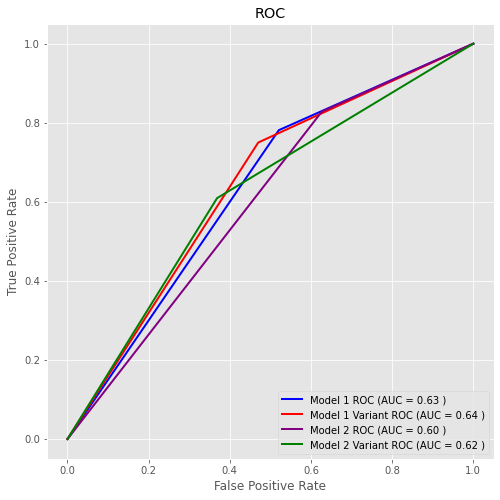

In [37]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr1, tpr1, _ = roc_curve(y_test[:,0], yhat1[:,0])
fpr2, tpr2, _ = roc_curve(y_test[:,0], yhat2[:,0])
fpr3, tpr3, _ = roc_curve(y_test[:,0], yhat3[:,0])
fpr4, tpr4, _ = roc_curve(y_test[:,0], yhat4[:,0])

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)

plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, color='blue', label=r'Model 1 ROC (AUC = %0.2f )' % (auc1), lw=2, alpha=1)
plt.plot(fpr2, tpr2, color='red', label=r'Model 1 Variant ROC (AUC = %0.2f )' % (auc2), lw=2, alpha=1)
plt.plot(fpr3, tpr3, color='purple', label=r'Model 2 ROC (AUC = %0.2f )' % (auc3), lw=2, alpha=1)
plt.plot(fpr4, tpr4, color='green', label=r'Model 2 Variant ROC (AUC = %0.2f )' % (auc4), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Looking at these curves and the area under the curve (AUC), we can see that the model 1 variant has the highest AUC of 0.64, model 1 comes in close second with an AUC of 0.63, followed by the model 2 variant with an AUC of 0.62, and lastly, the worst model is model 2 with an AUC of 0.6. We can see that each curve follows a similar path. The initial slope and the bend in the lines all look very similar. These ROC curves are clearly not ideal as we would want them much closer to the top left of the graph. This reflects how underwhelming our convolutional neural networks were and how difficult this classification task really is.

Relating these tests to our business case, these models should not be used in practice. At best, our model 1 variant achieved an F1-Score of about 0.63, nowhere near the needed accuracy/F1-score needed to implement into a social media application. Ideally, we were hoping achieve an F1-Score of 0.90 or above due to the sheer volume of images posted onto social media applications per day. With our performance, we would misclassify around 35% of images that are put through our model. For someone manually inspecting the flagged images, it would be a nightmare trying to figure out if the image was a false positive or false negative. 

### 2.4 Comparing CNN to Standard Multi-Layer Perceptron

Let's now see how our best performing convolutional neural network, our model 1 variation, to a standard MLP. For our MLP we decided to create a 5 layer neural network starting with a flatten layer, 2 dense layers with 128 neurons, 1 dense layer with 64 neurons, 1 dense layer with 32 neurons, and our output layer with 2 neurons. All layers use a ReLu activation, except for the output layer which uses softmax. We also decided to add some dropout between the first 3 dense layers. Like all other models in this report, we are using the default AdaM optimizer, categorical cross entropy as the loss function, and F1-Score as the evaluation metric. We also decided to train this model on the same number of epochs as our previous convolutional models to keep consistency across the models.

In [39]:
mlp = Sequential()

mlp.add(Input(shape=(HEIGHT, WIDTH, 1)))
mlp.add(Flatten())

mlp.add(Dense(units=128, activation='relu'))
mlp.add(Dropout(0.25))
mlp.add(Dense(units=128, activation='relu'))
mlp.add(Dropout(0.4))
mlp.add(Dense(units=64, activation='relu'))
mlp.add(Dense(units=32, activation='relu'))
mlp.add(Dense(units=2, activation='softmax'))

mlp.compile(optimizer=Adam(),
            loss='categorical_crossentropy',
            metrics=[f1])
mlp.summary()
hist5 = mlp.fit(datagen.flow(X_train, y_train, batch_size=64), 
                steps_per_epoch=int(len(X_train)/64),
                epochs=55,
                verbose=1,
                validation_data=(X_test,y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               720128    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

25/25 [==============================] - 1s 41ms/step - loss: 0.6635 - f1: 0.5756 - val_loss: 0.6600 - val_f1: 0.6182
Epoch 53/55
25/25 [==============================] - 1s 41ms/step - loss: 0.6737 - f1: 0.5850 - val_loss: 0.6637 - val_f1: 0.6214
Epoch 54/55
25/25 [==============================] - 1s 41ms/step - loss: 0.6726 - f1: 0.5781 - val_loss: 0.6607 - val_f1: 0.6147
Epoch 55/55
25/25 [==============================] - 1s 41ms/step - loss: 0.6653 - f1: 0.5906 - val_loss: 0.6648 - val_f1: 0.6135


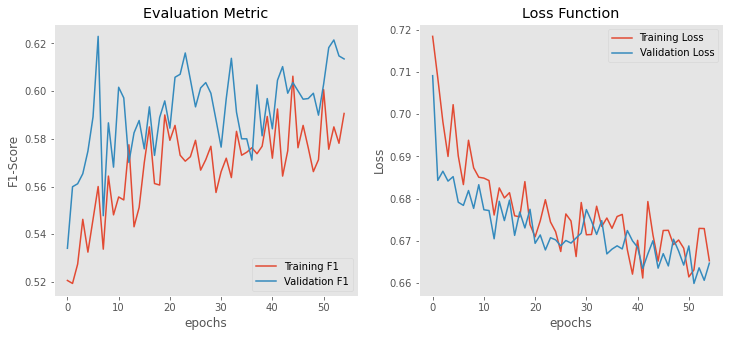

Loss: 0.6647640981126239 F1-Score: 0.6175961


In [40]:
plot_history(hist5)
loss, f1_score = mlp.evaluate(X_test, y_test, verbose=0)
print('Loss:', loss, 'F1-Score:', f1_score)

From the output above, it looks like an MLP could be a good option for this classification task (sadly). These results are comparable to our previous models with the MLP getting an F1-Score of 0.617 and loss of 0.664. This looks most comparable to our first model as the final metrics are similar. Additionally, this model took significantly less time to train compared to the convolutional neural networks. This model only took about a minute to train, whereas our convolutional models took anywhere from 5-25 minutes to train. The two graphs follow good trends and show no signs of overfitting.

Now lets run statistical tests between our best and worst convolutional models and the MLP to see how it compares.

In [41]:
yhat5 = np.round(mlp.predict(X_test))
err5 = 1 - f1(yhat5, y_test)

print('Error rate of MLP:', err5.numpy())
print('Error rate of best CNN:', err2.numpy())
print('Error rate of worst CNN:', err3.numpy())

d = np.abs(err5 - err2)
var = (err2 * (1-err2)/X_test.size) + (err5 * (1-err5)/X_test.size)
print('\nConfidence interval of MLP and best CNN:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err5 - err3)
var = (err3 * (1-err3)/X_test.size) + (err5 * (1-err5)/X_test.size)
print('Confidence interval of MLP and worst CNN:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

Error rate of MLP: 0.38141817
Error rate of best CNN: 0.3667482
Error rate of worst CNN: 0.413203

Confidence interval of MLP and best CNN: 0.0137857748742681 0.015554134679259733
Confidence interval of MLP and worst CNN: 0.030891052038641648 0.03267861291649751


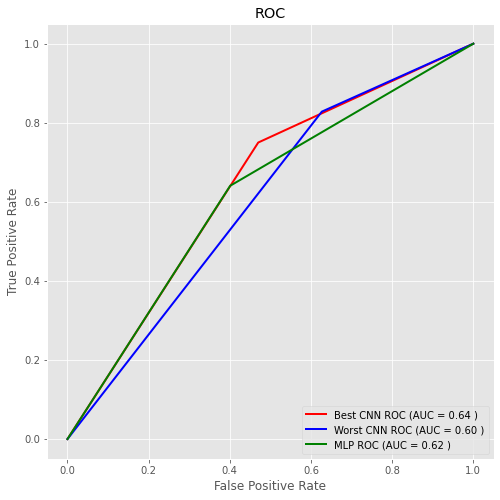

In [42]:
fpr5, tpr5, _ = roc_curve(y_test[:,0], yhat5[:,0])
auc5 = auc(fpr5, tpr5)


plt.figure(figsize=(8,8))
plt.plot(fpr2, tpr2, color='red', label=r'Best CNN ROC (AUC = %0.2f )' % (auc2), lw=2, alpha=1)
plt.plot(fpr3, tpr3, color='blue', label=r'Worst CNN ROC (AUC = %0.2f )' % (auc3), lw=2, alpha=1)
plt.plot(fpr5, tpr5, color='green', label=r'MLP ROC (AUC = %0.2f )' % (auc5), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

From these statistical tests and the graph of the ROC curve, our MLP is right in the middle (performance wise) of our best and worst convolutional models. Both statistical tests show statistical significance between the error rates of the models with the MLP performing better than our worst CNN, and worse than our best CNN. The ROC curves and AUC values further back up this claim as the MLP AUC is 0.62, 0.02 more than our worst CNN, and 0.02 less than our best CNN. 

Based on these tests, we believe a well designed MLP (or wide/deep network) could significantly outperform a convolutional neural network in both performance and training time. However, this is just a thought and much more testing and designing must be done to back up this statement. 

***

## 3 Exceptional Work

Opting for late turn-in, no exceptional work this time :(

***

## Resources

[1] Real & Fake Face Dataset. https://www.kaggle.com/ciplab/real-and-fake-face-detection

[2] Calculating F1-Score with Keras. https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

[3] Real & Fake Face Code Examples. https://www.kaggle.com/ciplab/real-and-fake-face-detection/code